In [1]:
# Автоматическая перезагрузка модулей при изменении
# Позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

In [26]:
# Импорт библиотек для машинного обучения и обработки текста
import pandas as pd
import numpy as np
import random

# Импорт sklearn для классических алгоритмов ML
from sklearn.model_selection import train_test_split, StratifiedKFold  # разделение данных и кросс-валидация
from sklearn.dummy import DummyClassifier  # наивный классификатор для бейслайна
from sklearn.compose import ColumnTransformer  # трансформация разных столбцов по-разному
from sklearn.pipeline import Pipeline  # создание пайплайнов обработки
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer  # векторизация текста
from sklearn.linear_model import LogisticRegression  # логистическая регрессия
from sklearn.tree import DecisionTreeClassifier  # дерево решений
from sklearn.ensemble import RandomForestClassifier  # случайный лес
from sklearn.base import clone  # клонирование моделей
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier  # градиентный бустинг

# Пользовательские модули
from helper import *  # вспомогательные функции
from plots import *   # функции визуализации
from nlp import *     # функции обработки естественного языка
from transformers import *  # функции для работы с трансформерами

In [3]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости
# Критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random

In [4]:
# Загружаем предобработанные данные
df = pd.read_csv('data/train.csv')

## 5. Препроцессинг данных

**Цель:** Подготовить данные для обучения моделей классического машинного обучения.
Включает очистку данных, токенизацию и создание признаков.

### 5.1 Общие преобразования

**Логика:** Приводим данные к стандартному формату для машинного обучения:
- Удаляем ненужные столбцы
- Очищаем от неинформативных записей  
- Токенизируем тексты для дальнейшей векторизации

In [5]:
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
# Создаем копию данных для предобработки
df_preprocessed = df.copy()

# Токенизируем тексты
# Это необходимо для дальнейшей векторизации текстов
df_preprocessed['Title'] = df_preprocessed['Title'].apply(tokenize_words)
df_preprocessed['Description'] = df_preprocessed['Description'].apply(tokenize_words)

In [16]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X, y = divide_data(df_preprocessed, 'Class Index')

## 6. Построение baseline

**Цель:** Создать базовые модели для сравнения с более сложными подходами.
Baseline показывает минимальный уровень качества, которого нужно достичь или превзойти.

In [27]:
# Определяем набор baseline моделей для сравнения:
models = [
    ('DummyClassifier', DummyClassifier(random_state=SEED, strategy='most_frequent')),  # наивный классификатор
    ('LogisticRegression', OneVsRestClassifier(LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear'))),  # линейная модель
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),  # дерево решений
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),  # случайный лес
    ('LGBMClassifier', LGBMClassifier(random_state=SEED, verbose=-1))  # градиентный бустинг
]

In [18]:
# Настраиваем стратифицированную кросс-валидацию с 5 фолдами
# StratifiedKFold гарантирует, что в каждом фолде будет примерно одинаковое соотношение классов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

### 6.1. CountVectorizer

**Логика:** CountVectorizer создает матрицу частот слов (bag of words).
Каждая ячейка содержит количество вхождений конкретного слова в документ.
Это простой, но эффективный способ представления текста для классических ML алгоритмов.

#### 6.1.1 Без очистки токенов

**Цель:** Проверить базовое качество с исходными токенами.
Это отправная точка для сравнения с очищенными версиями.

In [23]:
# Создаем пайплайн для векторизации текстов
count_vectorizer_preprocessor = Pipeline([
    ('vectorizer', ColumnTransformer(
        [
            # Векторизация заголовков: analyzer=lambda x: x означает, что вход уже токенизирован
            ('title_vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32), 'Title'),
            # Векторизация описаний: min_df=50 исключает слова, встречающиеся менее 50 раз
            ('description_vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32), 'Description'),
        ],
        remainder='passthrough',  # остальные столбцы передаем как есть
        verbose_feature_names_out=True  # для отладки имен признаков
    )),
])

In [24]:
df_preprocessed.head()

,Class Index,Title,Description
0,3,"[wall, st, bears, claw, back, into, the, black...","[reuters, short, sellers, wall, street, s, dwi..."
1,3,"[carlyle, looks, toward, commercial, aerospace...","[reuters, private, investment, firm, carlyle, ..."
2,3,"[oil, and, economy, cloud, stocks, outlook, re...","[reuters, soaring, crude, prices, plus, worrie..."
3,3,"[iraq, halts, oil, exports, from, main, southe...","[reuters, authorities, have, halted, oil, expo..."
4,3,"[oil, prices, soar, to, all, time, record, pos...","[afp, tearaway, world, oil, prices, toppling, ..."


c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 417, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Nocomp\AppData\Local

<Figure size 1500x600 with 0 Axes>

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 417, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Nocomp\AppData\Local

<Figure size 1500x600 with 0 Axes>

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 417, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Nocomp\AppData\Local

<Figure size 1500x600 with 0 Axes>

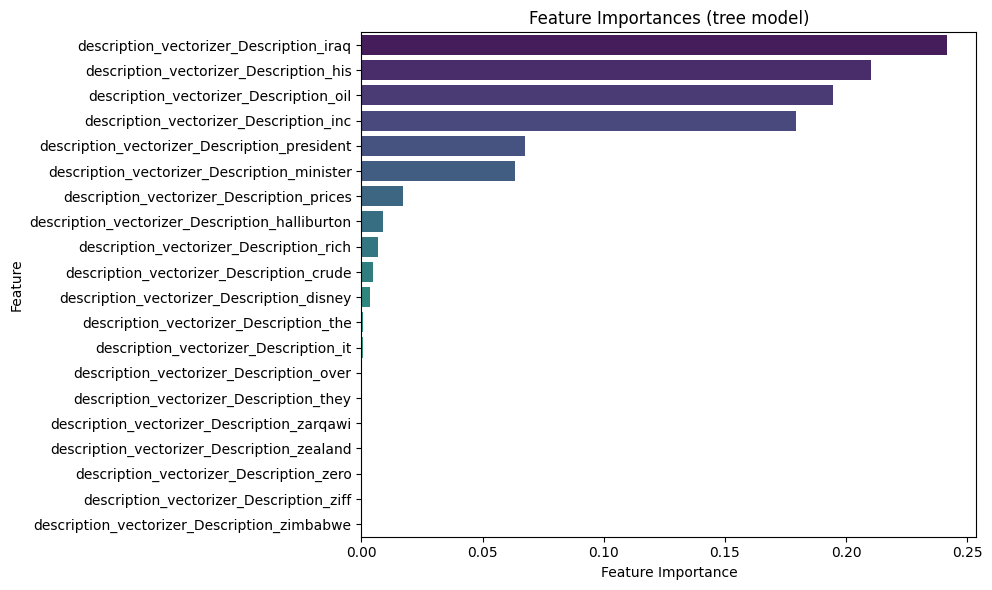

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 417, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Nocomp\AppData\Local

<Figure size 1500x600 with 0 Axes>

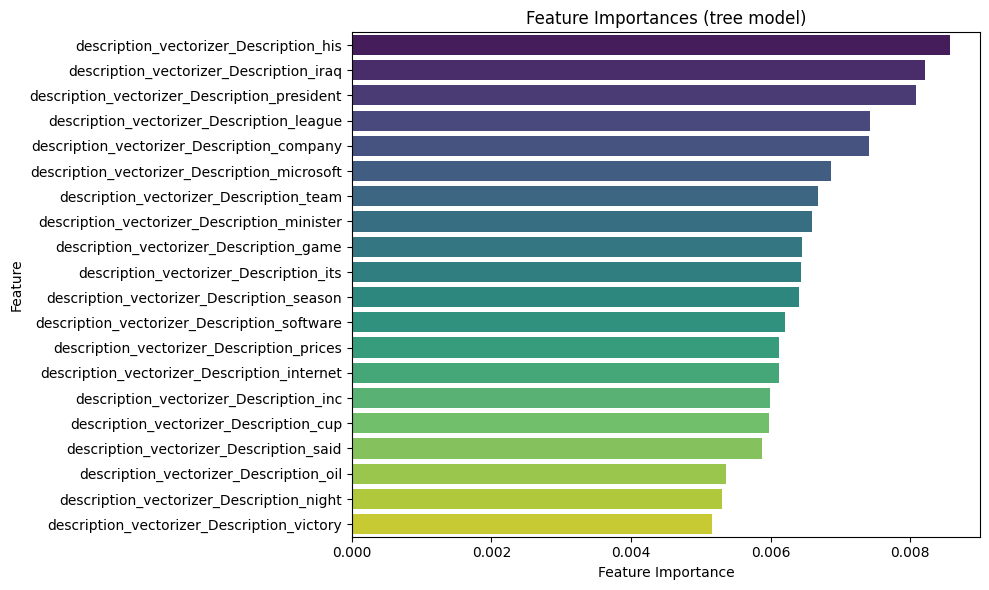

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Progr

<Figure size 1500x600 with 0 Axes>

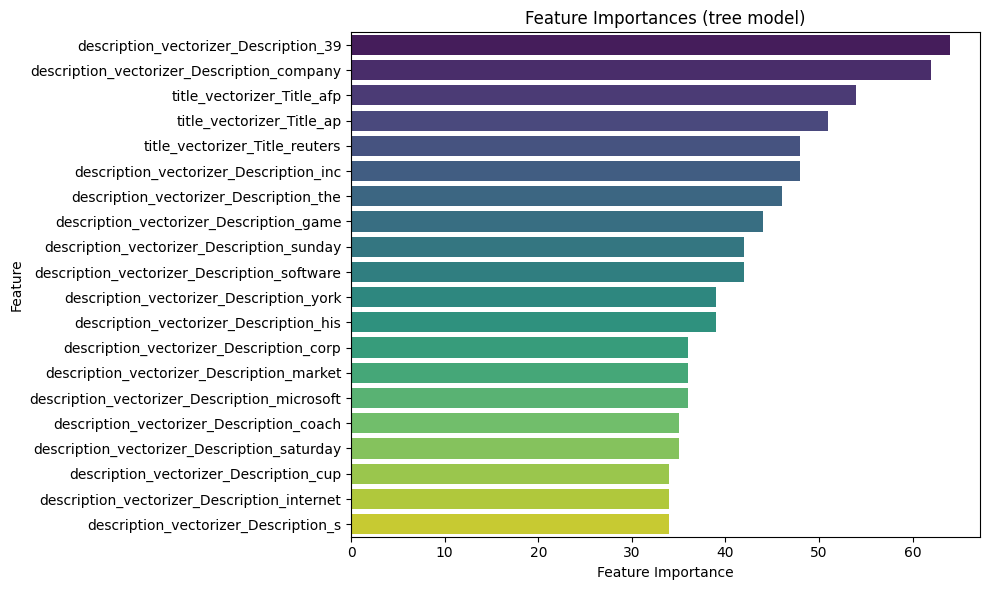

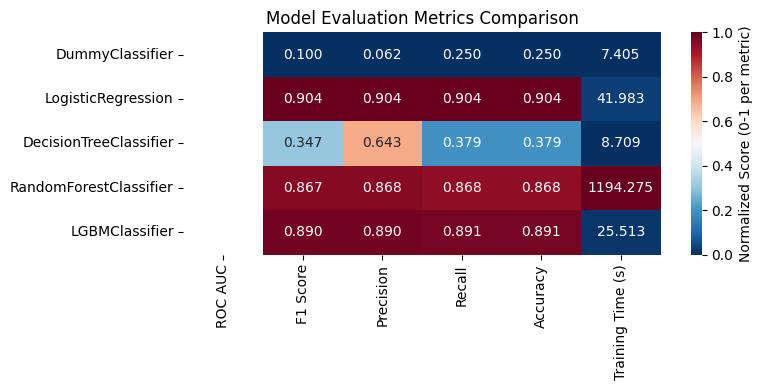

In [28]:
# Обучаем все baseline модели с кросс-валидацией
# Функция автоматически обучает каждую модель, оценивает метрики и строит графики важности признаков
count_vectorizer_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

**Анализ важности признаков:**

На графиках feature importance мы видим, что важными фичами стали знаки "-", "*", "**", ".". 
Это объясняется тем, что большинство описаний вакансий были в markdown формате и содержали эти спецсимволы:
- "-" отвечает за элементы списка
- "**" за жирный шрифт

**Вывод:** Хоть классический подход обработки текстов и предписывает удаление знаков препинания, 
в этом случае делать этого не стоит из-за риска потерять важные фичи. 
Но можно попробовать удалить стоп-слова.

#### 6.1.2 Удалим стоп-слова

**Логика:** Стоп-слова (артикли, предлоги, союзы) обычно не несут смысловой нагрузки.
Их удаление может улучшить качество модели и ускорить обучение.

In [29]:
# Создаем копию данных для экспериментов с очисткой
X_cleaned_tokens = X.copy()

# Удаляем стоп-слова из токенов, но оставляем пунктуацию
# lowercase_for_counting=True приводит все к нижнему регистру для корректного подсчета
X_cleaned_tokens[['Description', 'Title']] = X_cleaned_tokens[['Description', 'Title']].map(lambda tokens: filter_tokens(
    tokens, 
    remove_stopwords=True, 
    lowercase_for_counting=True
))

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 417, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Nocomp\AppData\Local

<Figure size 1500x600 with 0 Axes>

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 417, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Nocomp\AppData\Local

<Figure size 1500x600 with 0 Axes>

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 417, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Nocomp\AppData\Local

<Figure size 1500x600 with 0 Axes>

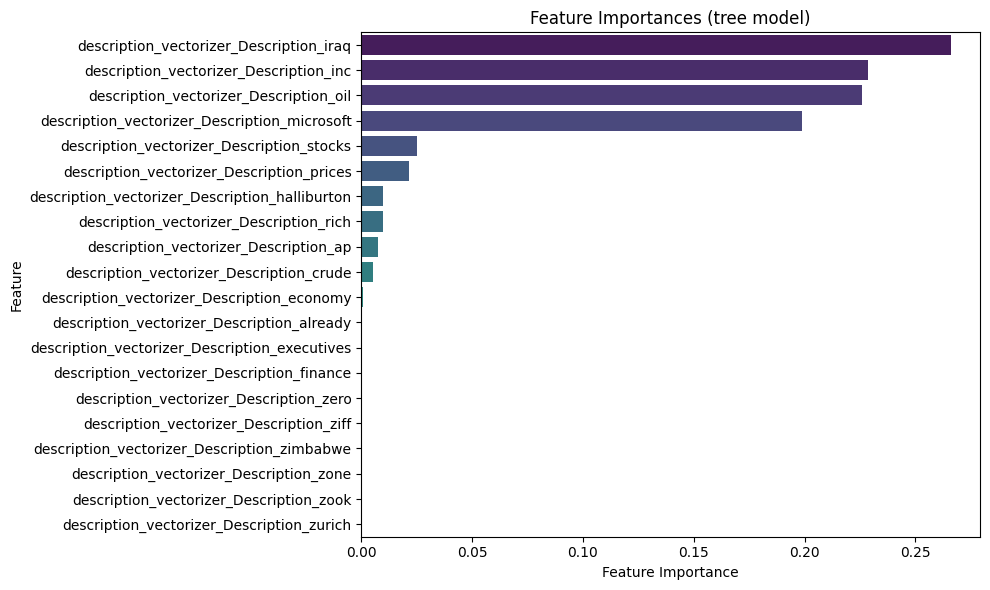

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 417, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Nocomp\AppData\Local

<Figure size 1500x600 with 0 Axes>

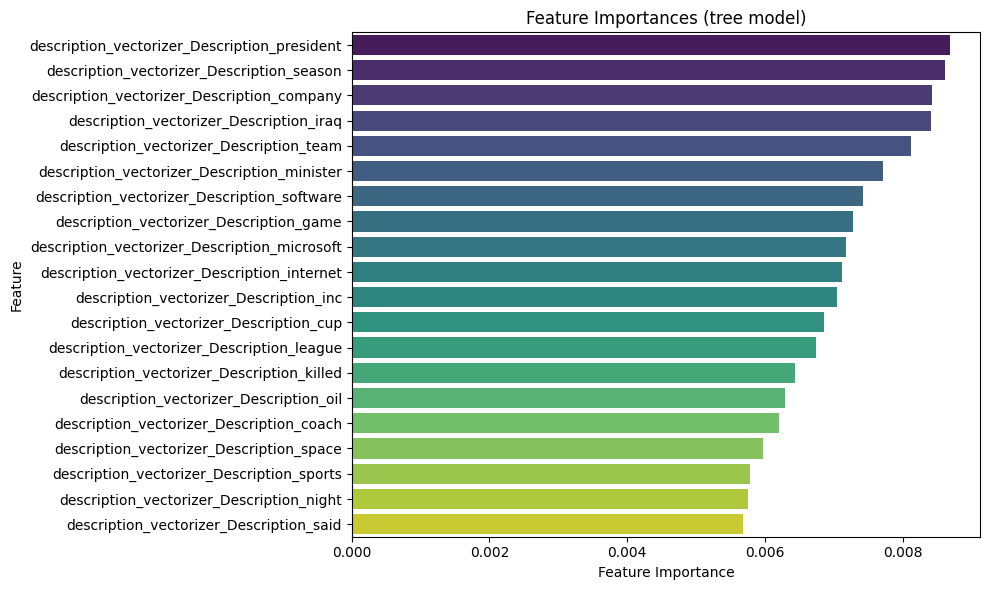

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:945: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 166, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\Nocomp\AppData\Local\Progr

<Figure size 1500x600 with 0 Axes>

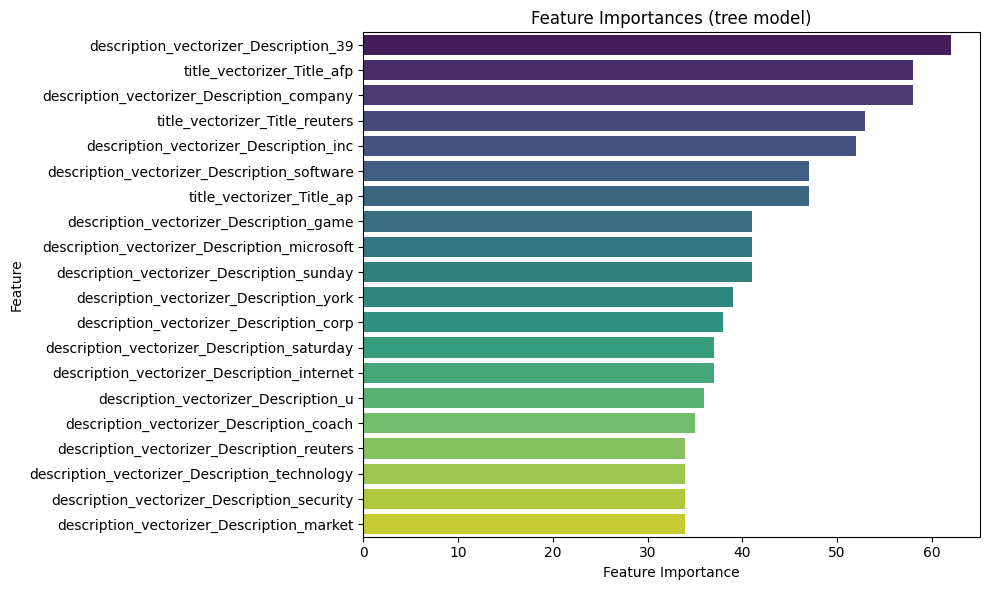

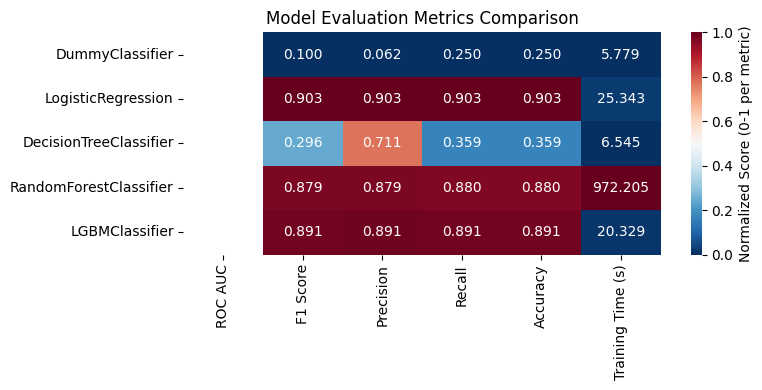

In [30]:
# Обучаем модели на очищенных от стоп-слов данных
# Сравним результаты с предыдущим экспериментом
count_vectorizer_cleaned_metrics = train_evaluate_models_cv(
    models=models,
    X=X_cleaned_tokens,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

In [32]:
# Сравниваем метрики моделей до и после удаления стоп-слов
# Тепловая карта покажет, улучшилось ли качество после очистки
compare_metrics_heatmap(count_vectorizer_metrics, count_vectorizer_cleaned_metrics)

AttributeError: 'MultipleModelResults' object has no attribute 'columns'

**Вывод по удалению стоп-слов:**

Изменение метрик незначительное, однако наблюдается ускорение времени обучения. 
Это преобразование оставим, так как:
1. Ускоряет обучение без потери качества
2. Стоп-слова в наших текстах не несут дополнительной смысловой нагрузки
3. Уменьшает размерность признакового пространства

#### 6.1.3 Топ 100 важных токенов

**Логика:** Вместо использования всех токенов, выбираем только самые важные для классификации.
Это может улучшить качество линейных моделей и ускорить обучение.

In [ ]:
# Создаем пайплайн с отбором топ-100 важных токенов
count_vectorizer_important_tokens_preprocessor = Pipeline([
    (
        'columns',
        ColumnTransformer([
            # Пайплайн для заголовков: сначала отбираем важные токены, потом векторизуем
            (
                'Title_pipeline',
                Pipeline([
                    ('token_selector', NgramFeatureSelector(top_k=100)),  # отбираем топ-100 токенов
                    ('vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32)),
                ]),
                'Title'
            ),
            # Аналогично для описаний
            (
                'description_pipeline',
                Pipeline([
                    ('token_selector', NgramFeatureSelector(top_k=100)),
                    ('vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32)),
                ]),
                'description'
            ),
        ],
            remainder='passthrough',
            verbose_feature_names_out=True
        )
    ),
])

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


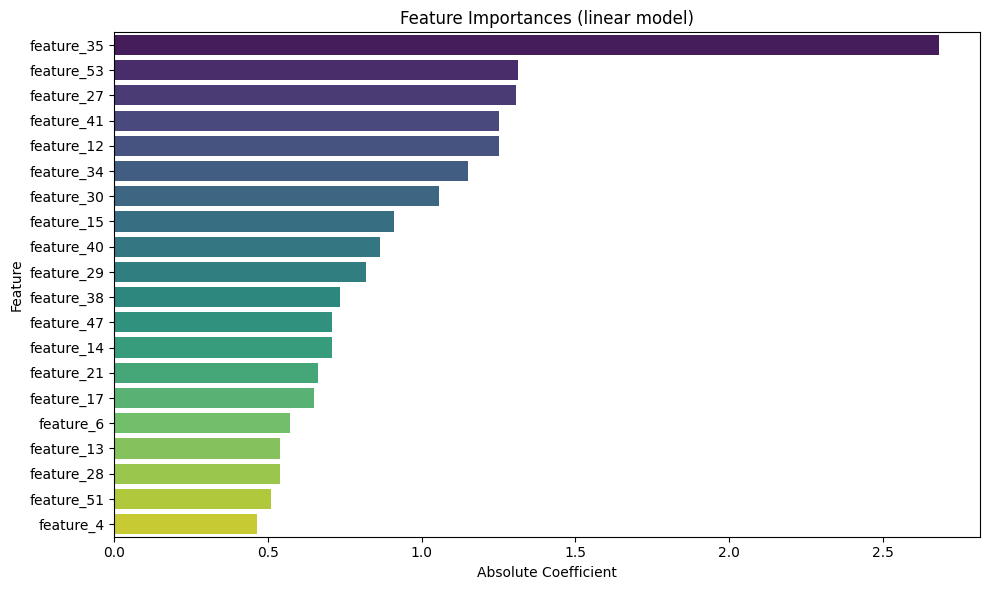

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


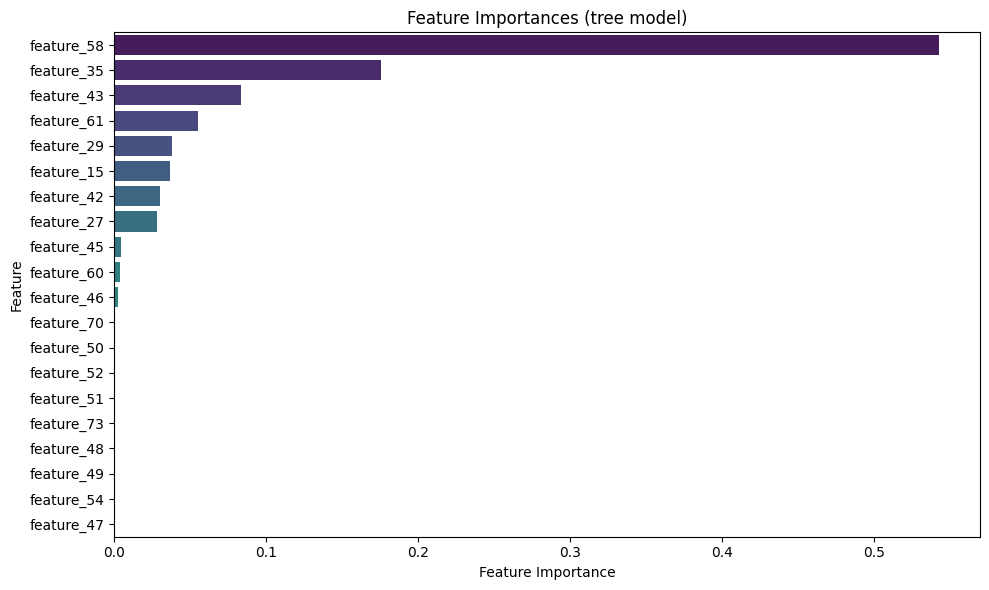

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


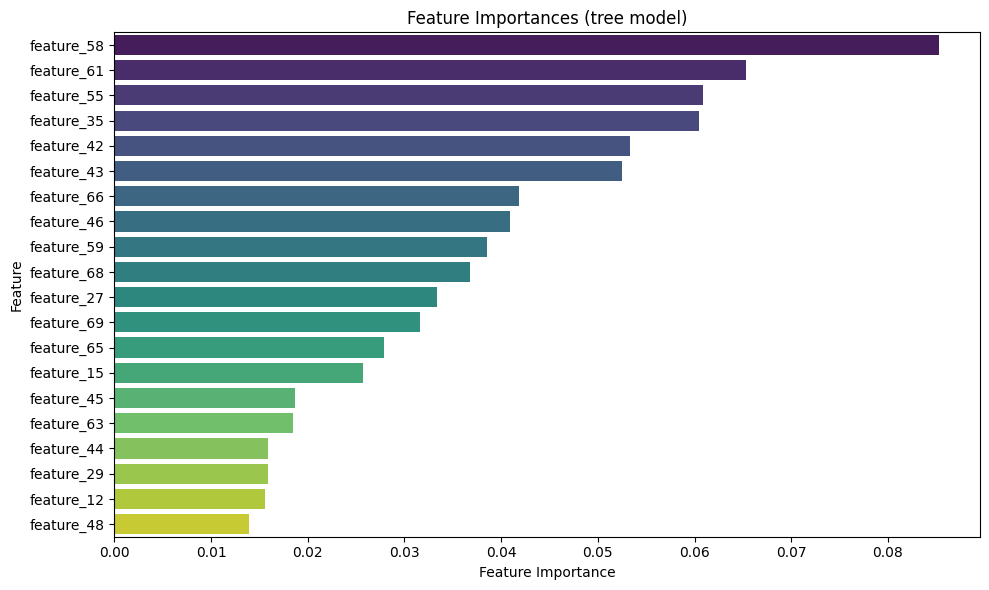

c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


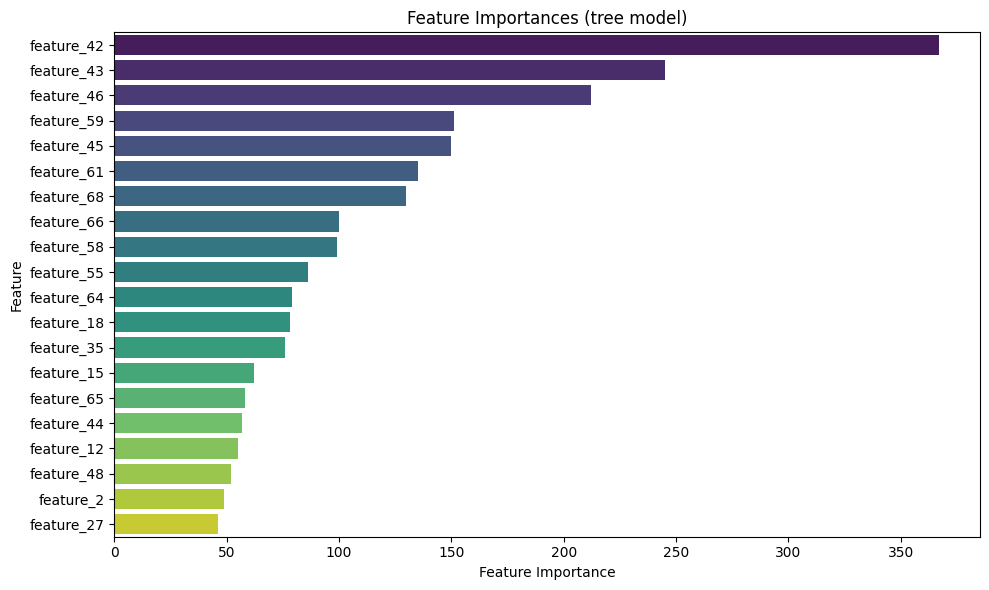

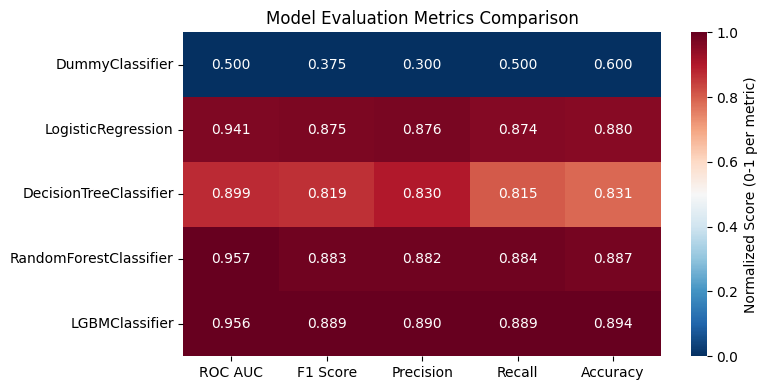

In [ ]:
# Обучаем модели с отбором важных токенов
# Используем исходные данные (не очищенные от стоп-слов), так как отбор токенов делается на основе важности
count_vectorizer_important_tokens_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=count_vectorizer_important_tokens_preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 DummyClassifier         0.000000  0.000000   0.000000  0.000000  0.000000
 LogisticRegression      0.025802  0.026171   0.025474  0.026716  0.024709
 DecisionTreeClassifier  0.002915  0.001731  -0.000552  0.001782  0.001238
 RandomForestClassifier  0.001773 -0.006651  -0.007342 -0.005957 -0.006792
 LGBMClassifier         -0.003420 -0.001647  -0.000014 -0.003112 -0.001242)

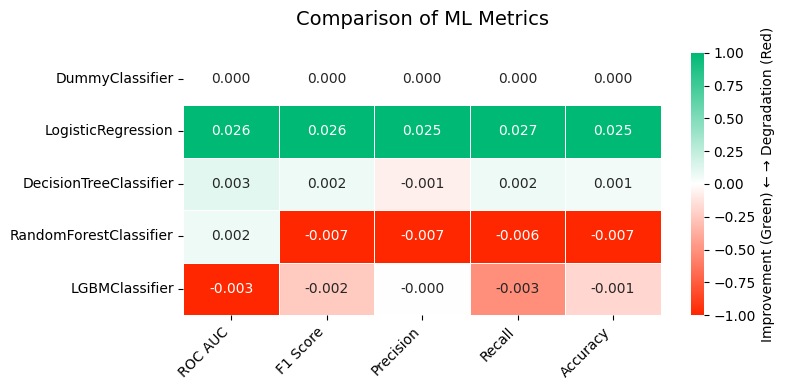

In [ ]:
# Сравниваем результаты с отбором важных токенов и без него
compare_metrics_heatmap(count_vectorizer_metrics, count_vectorizer_important_tokens_metrics)

**Вывод по отбору важных токенов:**

Удаление токенов, не входящих в топ 100 по важности улучшило метрики только для логистической регрессии. 
Это объясняется тем, что ансамбли деревьев смогли отобрать эти же токены на уровне алгоритмов.

**Проблемы:**
- Сильно увеличилось время обучения за счет долгого пересчета n-грамм
- Улучшение качества незначительное

**Рекомендация:** Применять такое преобразование имеет смысл только для линейных моделей.

### 6.2. TfidfVectorizer

**Логика:** TF-IDF (Term Frequency-Inverse Document Frequency) учитывает не только частоту слова в документе,
но и редкость слова в корпусе. Это может дать лучшие результаты, чем простой подсчет частот.

#### 6.2.1 Без очистки токенов

**Цель:** Проверить базовое качество TF-IDF векторизации с исходными токенами.

In [ ]:
# Создаем пайплайн для TF-IDF векторизации
tfidf_vectorizer_preprocessor = Pipeline([
    ('vectorizer', ColumnTransformer(
        [
            # TF-IDF векторизация заголовков: min_df=50 исключает редкие слова
            ('Title_vectorizer', TfidfVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32), 'Title'),
            # TF-IDF векторизация описаний
            ('description_vectorizer', TfidfVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32), 'description'),
        ],
        remainder='passthrough', 
        verbose_feature_names_out=True
    )),
])

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


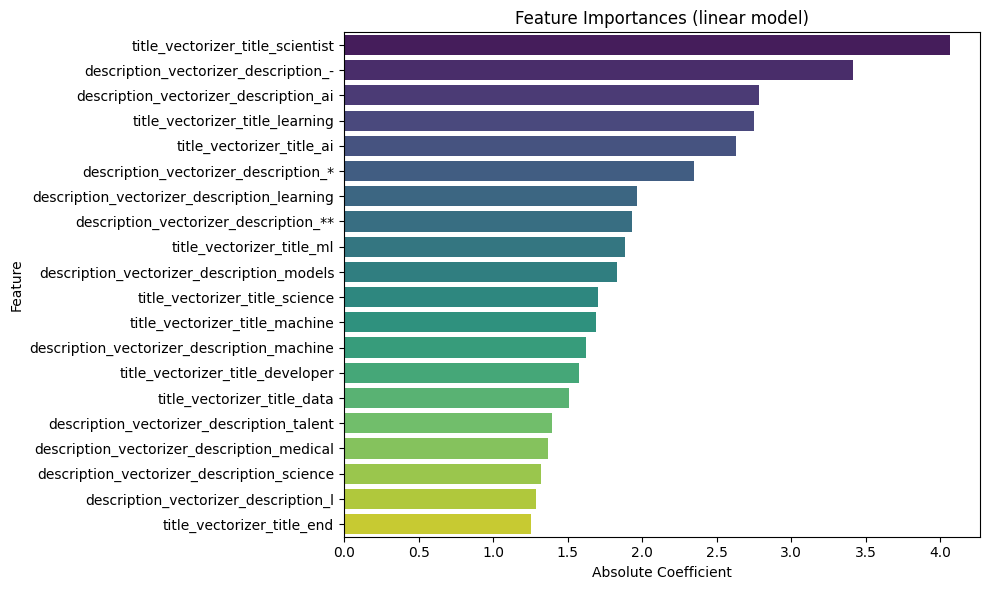

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


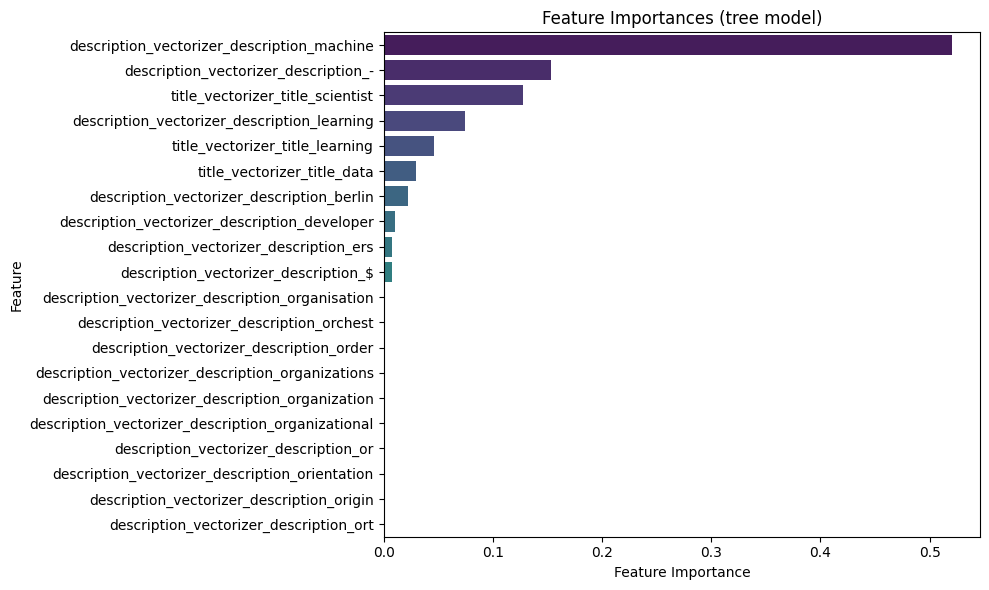

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


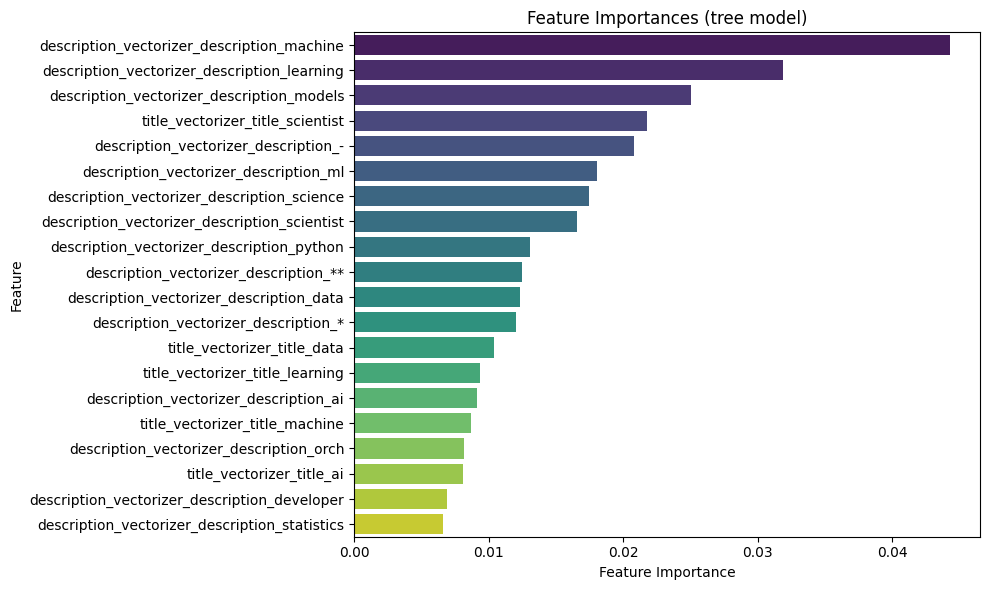

c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


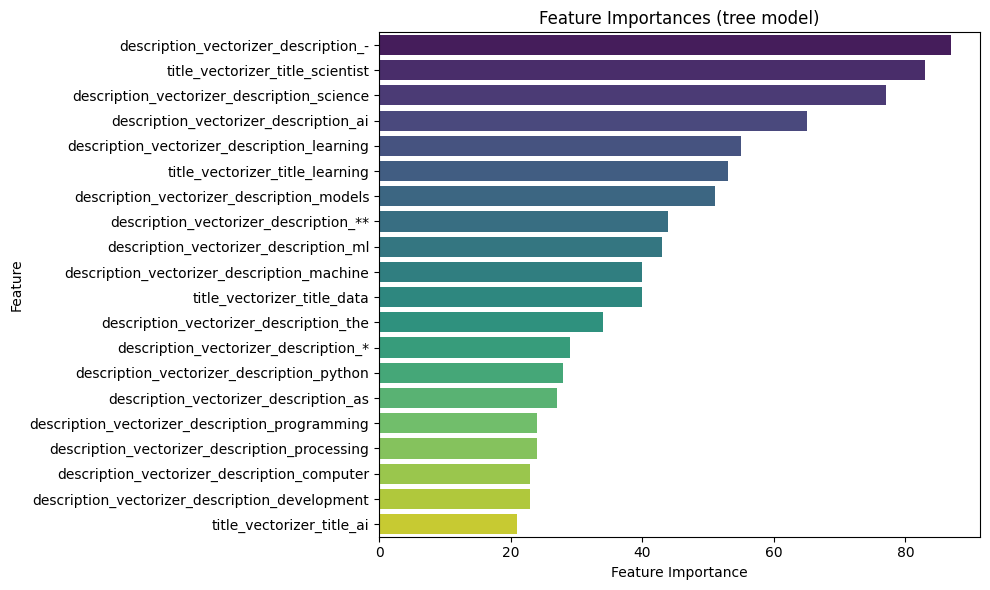

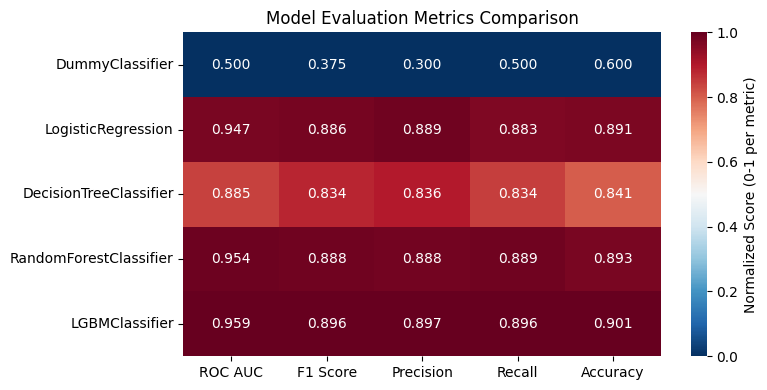

In [ ]:
# Обучаем модели с TF-IDF векторизацией на исходных данных
tfidf_vectorizer_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=tfidf_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 DummyClassifier         0.000000  0.000000   0.000000  0.000000  0.000000
 LogisticRegression      0.032132  0.037387   0.038590  0.036229  0.035810
 DecisionTreeClassifier -0.010812  0.016446   0.005289  0.021117  0.011749
 RandomForestClassifier -0.000357 -0.001102  -0.001538 -0.000765 -0.001229
 LGBMClassifier         -0.000379  0.005301   0.007224  0.003342  0.005556)

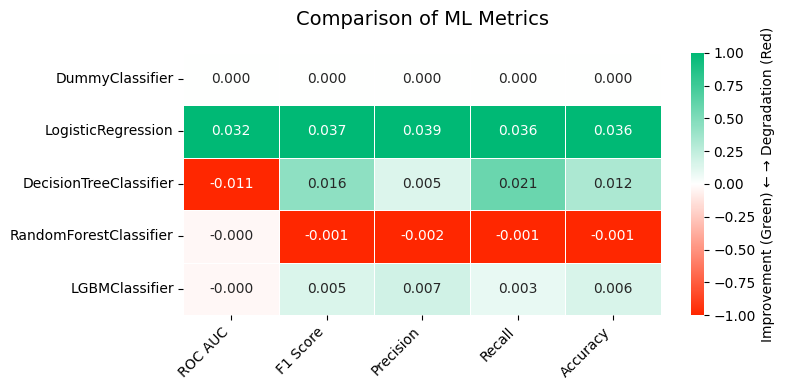

In [ ]:
# Сравниваем CountVectorizer и TfidfVectorizer
compare_metrics_heatmap(count_vectorizer_metrics, tfidf_vectorizer_metrics)

#### 6.2.2 Удаление стоп-слов

**Цель:** Проверить, улучшится ли качество TF-IDF после удаления стоп-слов.

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


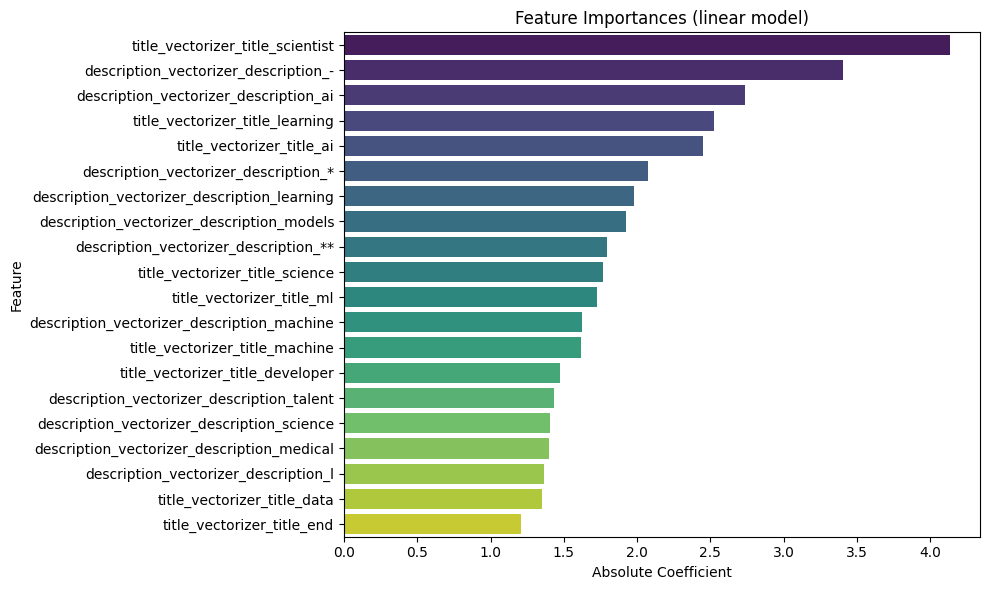

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


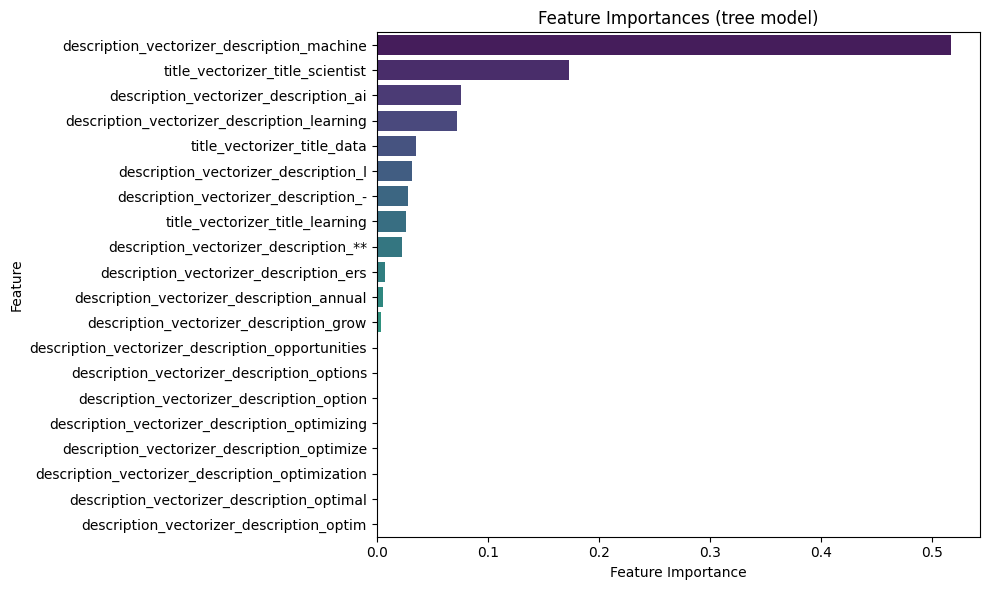

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


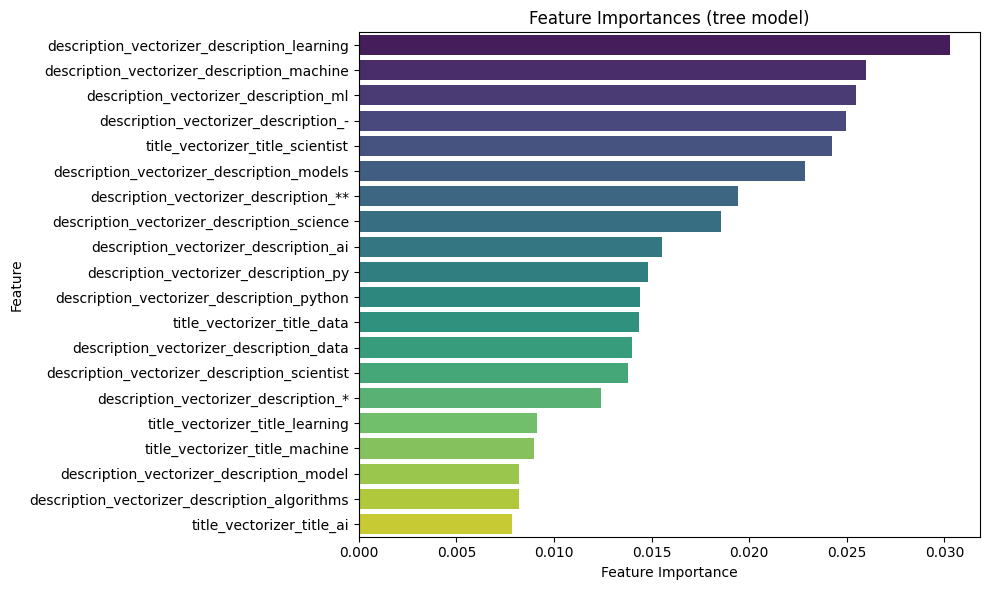

c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Apps\miniconda3\envs\tensorflow_gpu\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted w

<Figure size 1500x600 with 0 Axes>

d:\IT\DS\nlp-classification\plots.py:307: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


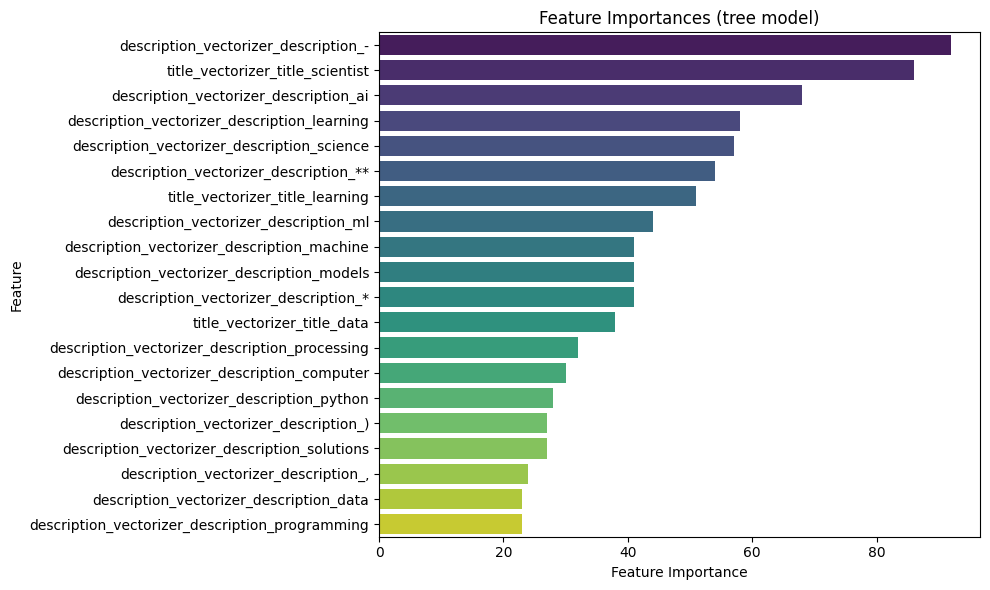

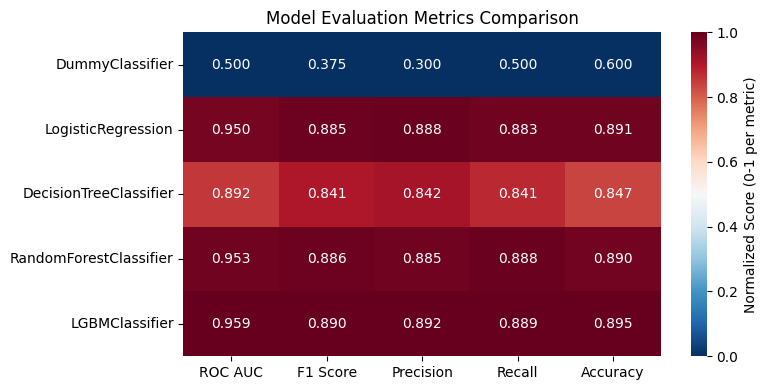

In [ ]:
# Обучаем TF-IDF модели на данных без стоп-слов
tfidf_vectorizer_clean_metrics = train_evaluate_models_cv(
    models=models,
    X=X_cleaned_tokens,
    y=y,
    preprocessor=tfidf_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC  F1 Score  Precision    Recall  Accuracy
 DummyClassifier         0.000000  0.000000   0.000000  0.000000  0.000000
 LogisticRegression      0.034539  0.043641   0.045105  0.042143  0.041987
 DecisionTreeClassifier -0.006652  0.021561   0.010029  0.026528  0.016684
 RandomForestClassifier  0.001941  0.005584   0.005610  0.004597  0.005556
 LGBMClassifier         -0.000188  0.000235   0.001939 -0.001048  0.000613)

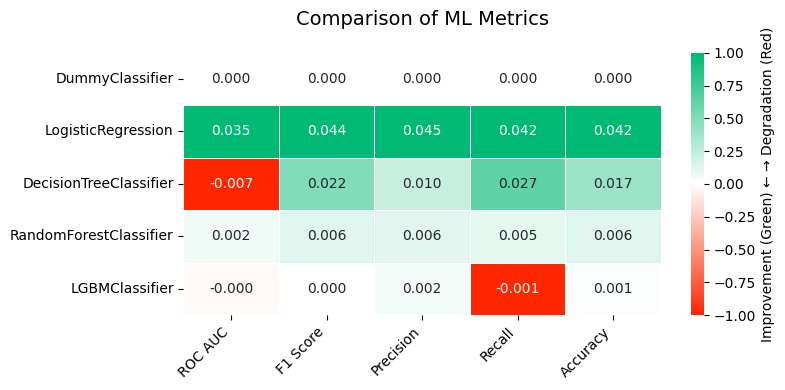

In [ ]:
# Сравниваем CountVectorizer и TfidfVectorizer на очищенных данных
compare_metrics_heatmap(count_vectorizer_cleaned_metrics, tfidf_vectorizer_clean_metrics)

### 7. Выводы по baseline моделям

**Лучший результат:** CountVectorizer с удалением стоп-слов показал наилучшие результаты среди всех baseline подходов.

**Ключевые находки:**
1. **CountVectorizer vs TfidfVectorizer:** CountVectorizer показал лучше результаты для данной задачи
2. **Удаление стоп-слов:** Улучшает качество и ускоряет обучение
3. **Отбор важных токенов:** Помогает только линейным моделям, но замедляет обучение
4. **Пунктуация:** В данной задаче информативна из-за markdown формата описаний

### План дальнейшего развития

**Улучшения предобработки:**
- убрать отдельно стоп-слова и отдельно пунктуацию

**Классические подходы к векторизации:**
- Count vectorizer (частота вхождения каждого токена в текст) ✅
- TFIDF vectorizer ✅
- HashingVectorizer

**Нейросетевые подходы:**
- кастомная нейронка (RNN)
- кастомная нейронка (LSTM) 
- кастомная нейронка (CNN)
- pre-trained эмбеддинги для слов (GloVe и другие)
- предобученные модели с классификацией (transformers, BERT)

**Гибридные подходы:**
- эмбеддинги из обученных ранее моделей
- эмбеддинги из предобученных моделей (transformers, BERT)
- OpenAI эмбеддинги (и другие LLM)

**Улучшения токенизации:**
- другие более умные токенизаторы
- учет domain specific слов
- удаление стоп-слов и знаков препинания
- оставить только топ-x токенов по метрике
- удалить токены с высокой корреляцией